In [1]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np
import re
from pathlib import Path
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Utilities
import itertools

# Custom functions and modules
from ml_model_training import train_xgboost
from kmeans_clustering import cluster_create_sub_dataframes
from plot_functions import plot_everything

import xgboost as xgb

import sys
sys.path.append('/projectnb/peaclab-mon/boztop/resource-allocation/python_scripts')

from ml_model_training import train_xgboost
from kmeans_clustering import cluster_create_sub_dataframes
from plot_functions import plot_everything
from feature_selection import (
    xgboost_feature_selection, 
    random_forest_feature_importance, 
    correlation_feature_selection
)


In [2]:
# Column headers, extracted from the "man 5 accounting" command:
col_headers=["qname", "hostname", "group", "owner", "job_name", "job_number", "account", "priority", 
             "submission_time", "start_time", "end_time", "failed", "exit_status", "ru_wallclock", 
             "ru_utime", "ru_stime", "ru_maxrss", "ru_ixrss", "ru_ismrss", "ru_idrss", "ru_isrss", 
             "ru_minflt", "ru_majflt", "ru_nswap", "ru_inblock", "ru_oublock", "ru_msgsnd", 
             "ru_msgrcv", "ru_nsignals", "ru_nvcsw", "ru_nivcsw", "project", "department", "granted_pe", 
             "slots", "task_number", "cpu", "mem", "io", "category", "iow", "pe_taskid", "maxvmem", 
             "arid", "ar_submission_time"]

use_col_headers = ["group", "owner", "job_name", "account", 
             "submission_time", "start_time", "end_time", "failed", "exit_status", "ru_wallclock", 
             "ru_utime", "ru_stime", "ru_maxrss", "ru_isrss", "project", "granted_pe", 
             "slots", "cpu", "mem", "io", "category"]

In [3]:
# Input file path
file_path = "/projectnb/peaclab-mon/boztop/resource-allocation/datasets/bu_scc/bu.accounting.2023" 

# Reading the utf-8 encoded CSV file
df = pd.read_csv(file_path, encoding='utf-8', skiprows=4, 
                 names=col_headers, sep=':')

In [4]:
# Remove any rows where wallclock is 0
df = df[df['ru_wallclock'] != 0]

# Keep the successful jobs only
df = df[df['failed'] == 0]
df = df[df['exit_status'] == 0]

# Add a column for the lag time
df['lag_time'] = df['start_time'] - df['submission_time']

# Remove any rows where this new column is <= 0
df = df[df['lag_time'] > 0]

df = df.dropna()

In [5]:
# Add additional metrics
df['execution_time'] = df['end_time'] - df['start_time']

# CPU-related
df['total_cpu_time'] = df['ru_utime'] + df['ru_stime']
df['ncpu'] = np.ceil(df['total_cpu_time'] / df['ru_wallclock'])
df['cpu_waste'] = df['slots'] - df['ncpu']

df['submission_time'] = df['submission_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [6]:
# --- LET'S MAKE SOME OBSERVATIONS! ---
print(f"Total number of jobs in the dataset: {df.shape[0]}")

# The total number of project groups
print(f"Total number of different groups: {df['group'].nunique()}")

print(f"Number of unique users: {df['owner'].nunique()}")
      
      

Total number of jobs in the dataset: 11403153
Total number of different groups: 524
Number of unique users: 1388


In [7]:
df = df.drop(['account','job_number','failed','exit_status','iow','pe_taskid','arid','ar_submission_time'], axis=1)

df.columns

Index(['qname', 'hostname', 'group', 'owner', 'job_name', 'priority',
       'submission_time', 'start_time', 'end_time', 'ru_wallclock', 'ru_utime',
       'ru_stime', 'ru_maxrss', 'ru_ixrss', 'ru_ismrss', 'ru_idrss',
       'ru_isrss', 'ru_minflt', 'ru_majflt', 'ru_nswap', 'ru_inblock',
       'ru_oublock', 'ru_msgsnd', 'ru_msgrcv', 'ru_nsignals', 'ru_nvcsw',
       'ru_nivcsw', 'project', 'department', 'granted_pe', 'slots',
       'task_number', 'cpu', 'mem', 'io', 'category', 'maxvmem', 'lag_time',
       'execution_time', 'total_cpu_time', 'ncpu', 'cpu_waste'],
      dtype='object')

In [8]:
def parse_h_rt_flag(column):
    parsed_data = []
    for entry in column:
        # Find all parts starting with '-l'
        matches = re.findall(r'-l ([^\s-]+)', entry)
        h_rt_value = None  # Default to None if h_rt is not present
        for match in matches:
            for item in match.split(','):
                if item.startswith('h_rt='):
                    _, value = item.split('=', 1)
                    h_rt_value = int(value)  # Cast the value to int
        parsed_data.append({'h_rt': h_rt_value})
    return parsed_data

# Apply the parsing function
parsed_flags = parse_h_rt_flag(df['category'])

# Convert parsed data to a DataFrame
parsed_df = pd.DataFrame(parsed_flags)

# Merge the parsed 'h_rt' column back to the original DataFrame
df = pd.concat([df, parsed_df], axis=1)

# Default hard time limit is 12 hours
df['h_rt'] = df['h_rt'].fillna(12 * 60 * 60).astype(int)


In [9]:
df['execution_time'] = df['execution_time'].fillna(0)


# Finding Optimal Feature for Prediction

In [11]:
numerical_submission_features = ['slots']

categorical_submission_features = ['group', 'owner', 'job_name', 'department', 'granted_pe']

label_encoders = {col: LabelEncoder() for col in categorical_submission_features}

for col in categorical_submission_features:
    df[col] = label_encoders[col].fit_transform(df[col])
    
    

In [ ]:
def find_optimal_feature_set(features, pred_feature, title, xlabel):
    X = df[features]
    y = df[pred_feature]
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rmse_values = []
    combinations = []
    
    for r in range(4,6):
        print(f'Iteration: {r}')
        for combo in itertools.combinations(features, r):
            print(f'Feature Combination: {list(combo)}')
            X_train_combo = X_train[list(combo)]
            X_test_combo = X_test[list(combo)]

            model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
            model.fit(X_train_combo, y_train)

            y_pred = model.predict(X_test_combo)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            rmse_values.append(rmse)
            combinations.append(', '.join(combo))
        
    sorted_indices = np.argsort(rmse_values)[::-1]
    sorted_rmse_values = np.array(rmse_values)[sorted_indices]
    sorted_combinations = np.array(combinations)[sorted_indices]

    norm = plt.Normalize(vmin=min(sorted_rmse_values), vmax=max(sorted_rmse_values))
    colors = cm.viridis(norm(sorted_rmse_values)) 

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_combinations, sorted_rmse_values, color=colors)

    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    cbar.set_label('RMSE', fontsize=12)

    plt.xlabel(f'{xlabel}', fontsize=14)
    plt.ylabel('Feature Combination', fontsize=14)
    plt.yticks(rotation=45)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.xticks(fontsize=14)
    plt.title(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.show()

    
    

In [ ]:
find_optimal_feature_set(['group', 'owner', 'job_name', 'department', 'granted_pe','slots'], 'cpu', 'RMSE Values for Each Input Feature Combination', 'RMSE (CPU-seconds)')



# XGBoost Experiments

In [ ]:
rmse = np.sqrt(((df['slots'] - df['ncpu']) ** 2).mean())

print(f"RMSE: {rmse}")

In [ ]:
train_features = ['group', 'owner', 'job_name', 'department', 'granted_pe','slots']

In [ ]:
rmse, mae, r2, y_test, y_pred, req_test = train_xgboost(df, 'BU SCC Dataset', 'ncpu', train_features , 'slots')

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


In [ ]:
sub_dfs = cluster_create_sub_dataframes(df, train_features, ['ncpu'], 10)

rmse_list = []
mae_list = []
r2_list = []

metrics_data = []
overprediction_sums = []

for i, sub_df in enumerate(sub_dfs):
    print(f"Processing cluster {i+1}/{len(sub_dfs)}")
    
    rmse, mae, r2, y_test, y_pred, req_test= train_xgboost(sub_df, 'BU SCC Dataset', 'ncpu', train_features, 'slots')
    
    if rmse is not None:
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        total_jobs = len(y_test)
        requested_gt_target = (req_test > y_test).sum()
        predicted_lt_actual = (y_pred < y_test).sum()
        predicted_gt_actual = (y_pred > y_test).sum()

        op1 = y_pred > y_test
        op2 = req_test > y_test
        
        sum_predicted_minus_actual = (y_pred[op1] - y_test[op1]).sum()
        sum_requested_minus_actual = (req_test[op2] - y_test[op2]).sum()

        metrics_data.append([i + 1, total_jobs, requested_gt_target, predicted_lt_actual, predicted_gt_actual])
        overprediction_sums.append([sum_predicted_minus_actual, sum_requested_minus_actual])

        


rmse = np.mean(rmse_list)
print(f"Average RMSE for Clustering: {rmse:.4f}")
mae = np.mean(mae_list)
print(f"Average MAE for Clustering: {mae:.4f}")
r2 = np.mean(r2_list)
print(f"Average R^2 for Clustering: {r2:.4f}")


plot_everything(metrics_data, overprediction_sums, 
                'NCPU Experiment on BU SCC Dataset: Over and Under Prediction Analysis ', 
                'BU SCC Dataset: Sum of Differences in Overprediction Cases Across Clusters',
                'Number of CPU Cores')


# Execution Time Prediction

In [12]:
rmse = np.sqrt(((df['execution_time'] - df['h_rt']) ** 2).mean())

print(f"RMSE: {rmse}")

RMSE: 162498.72472147134


In [13]:
train_features = ['group', 'owner', 'job_name', 'department', 'granted_pe','slots']

Train size (X_train): 9122521
Test size (X_test): 2280631
Train size (y_train): 9122521
Test size (y_test): 2280631


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

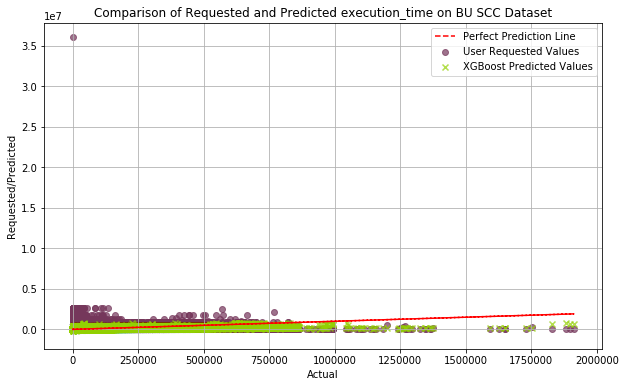

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


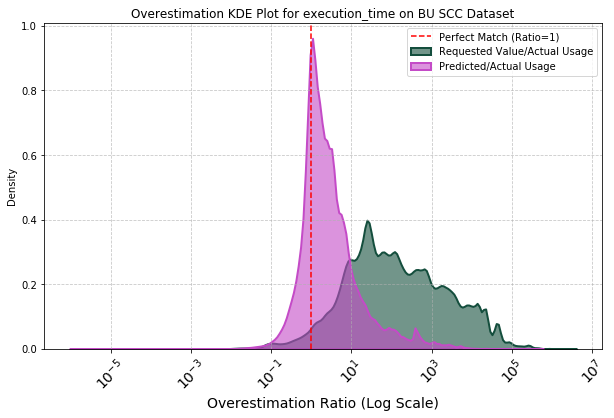

RMSE: 20217.0158
MAE: 4039.8523
R^2: 0.7844


In [14]:
rmse, mae, r2, y_test, y_pred, req_test = train_xgboost(df, 'BU SCC Dataset', 'execution_time', train_features , 'h_rt')

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Processing cluster 1/10
Train size (X_train): 1373009
Test size (X_test): 343253
Train size (y_train): 1373009
Test size (y_test): 343253


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

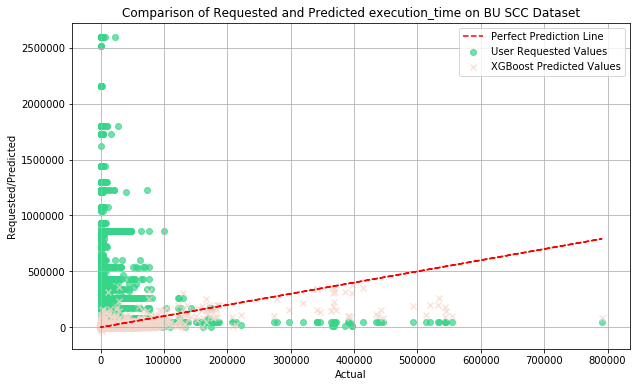

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


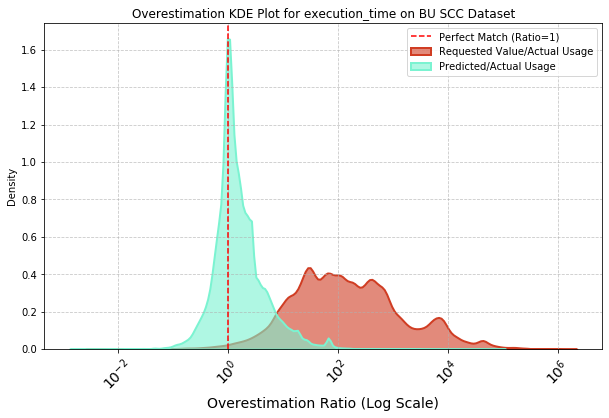

Processing cluster 2/10
Train size (X_train): 1548308
Test size (X_test): 387077
Train size (y_train): 1548308
Test size (y_test): 387077


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

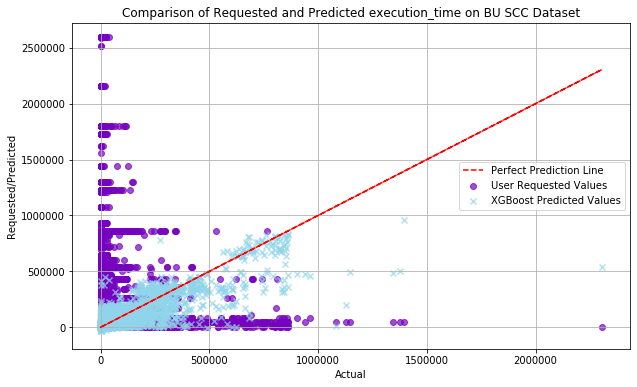

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


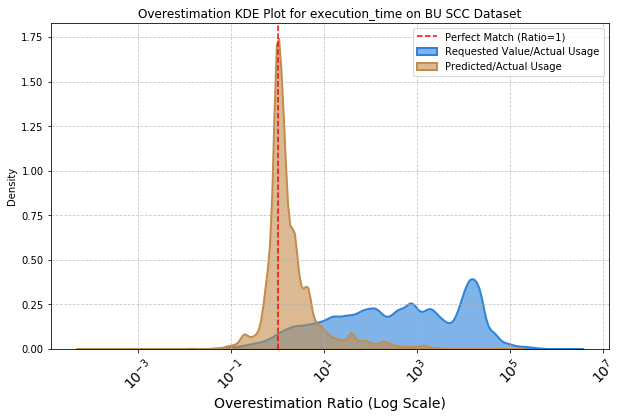

Processing cluster 3/10
Train size (X_train): 777764
Test size (X_test): 194441
Train size (y_train): 777764
Test size (y_test): 194441


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


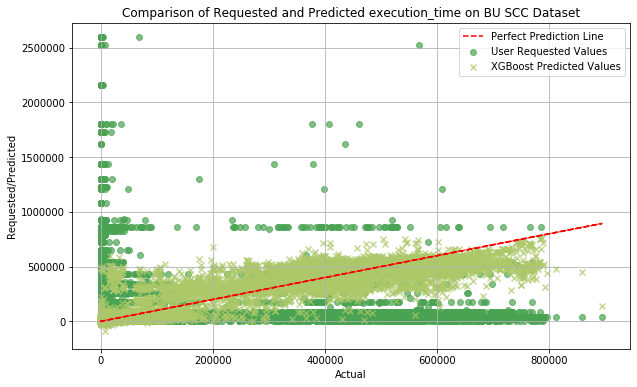

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


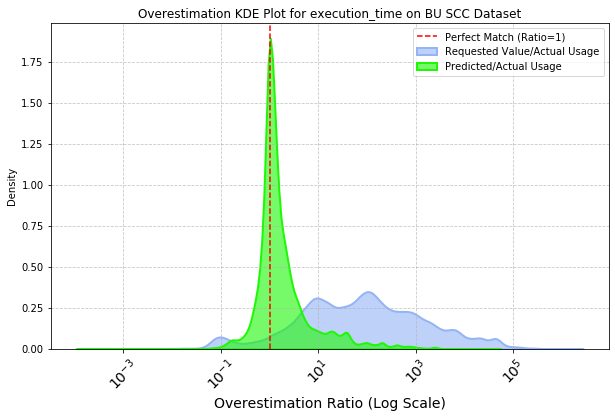

Processing cluster 4/10
Train size (X_train): 361735
Test size (X_test): 90434
Train size (y_train): 361735
Test size (y_test): 90434


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


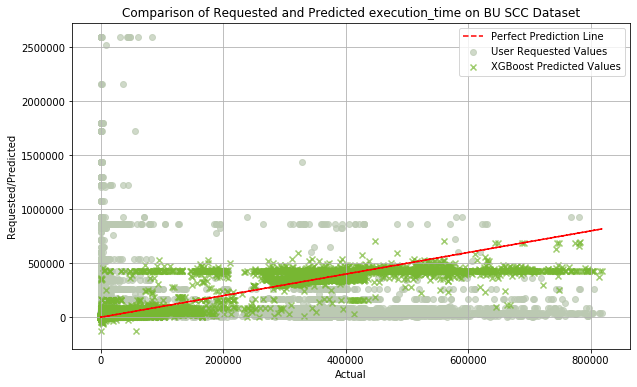

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


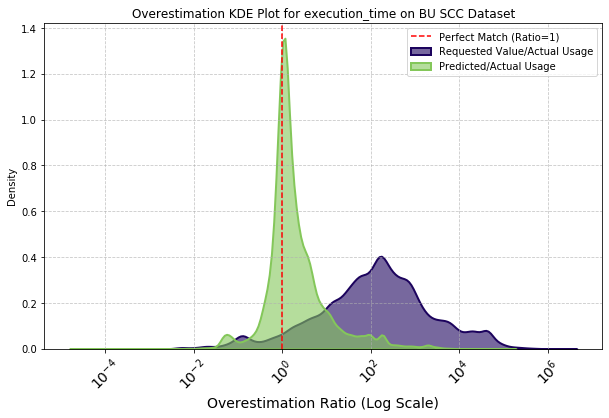

Processing cluster 5/10
Train size (X_train): 279611
Test size (X_test): 69903
Train size (y_train): 279611
Test size (y_test): 69903


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


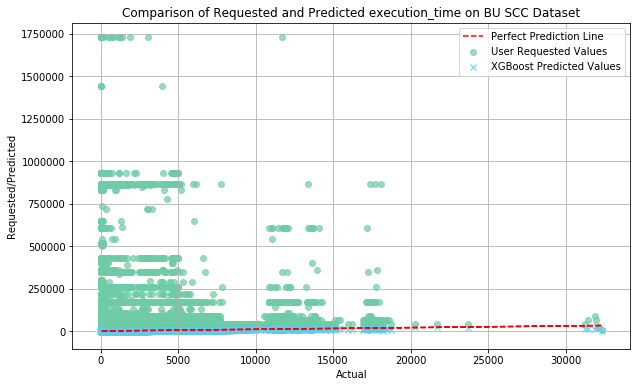

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


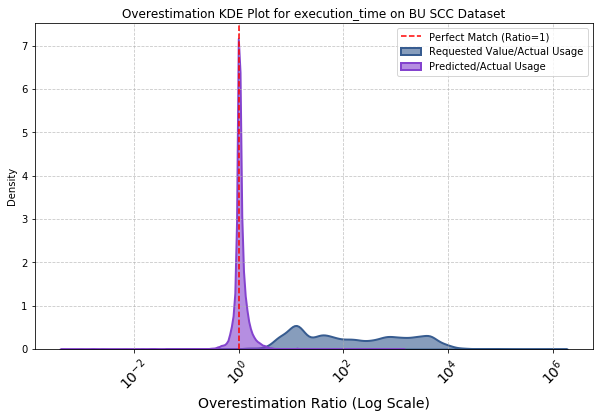

Processing cluster 6/10
Train size (X_train): 406926
Test size (X_test): 101732
Train size (y_train): 406926
Test size (y_test): 101732


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


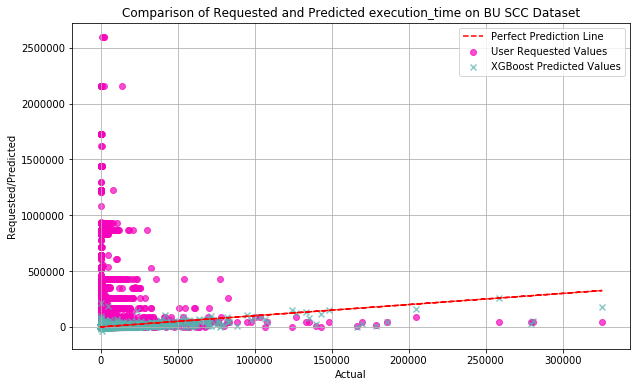

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


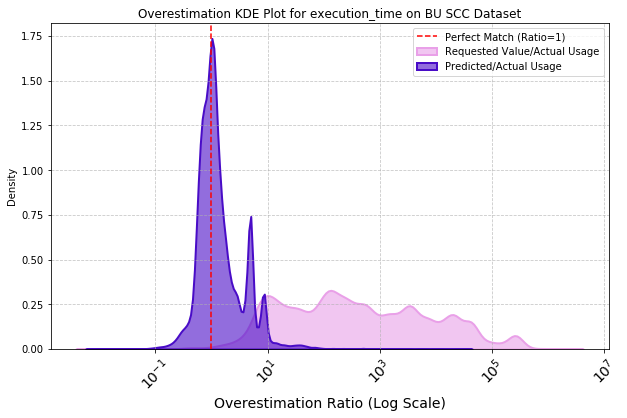

Processing cluster 7/10
Train size (X_train): 503046
Test size (X_test): 125762
Train size (y_train): 503046
Test size (y_test): 125762


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


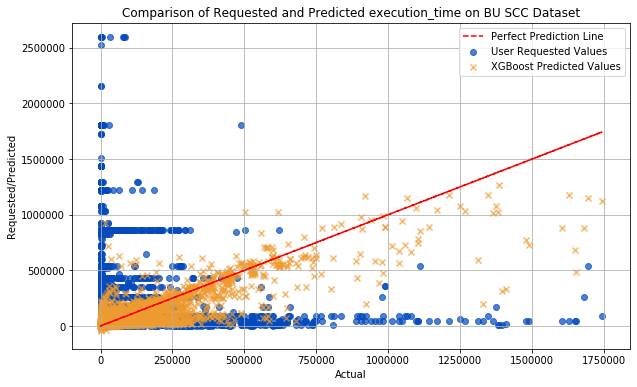

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


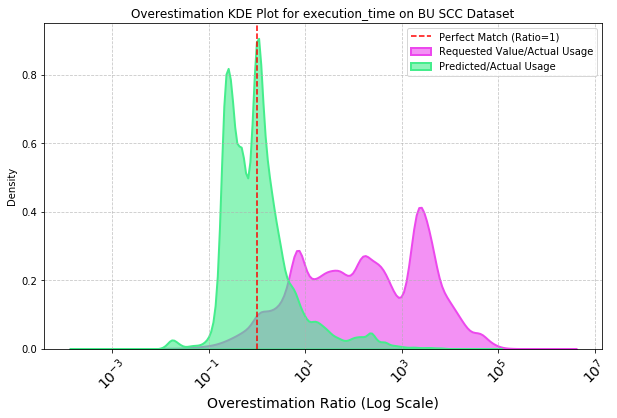

Processing cluster 8/10
Train size (X_train): 1781213
Test size (X_test): 445304
Train size (y_train): 1781213
Test size (y_test): 445304


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

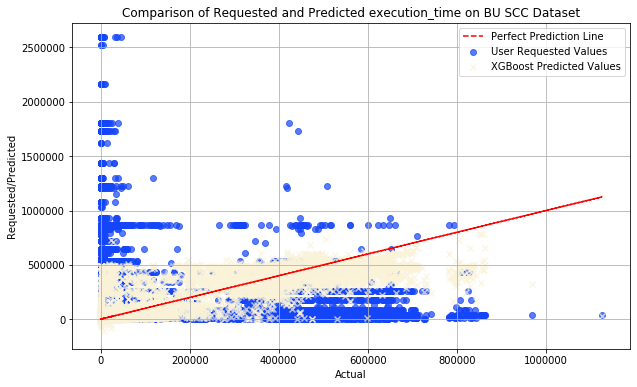

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


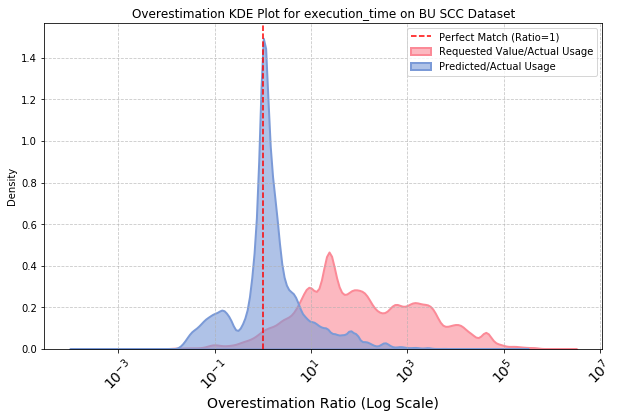

Processing cluster 9/10
Train size (X_train): 576513
Test size (X_test): 144129
Train size (y_train): 576513
Test size (y_test): 144129


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


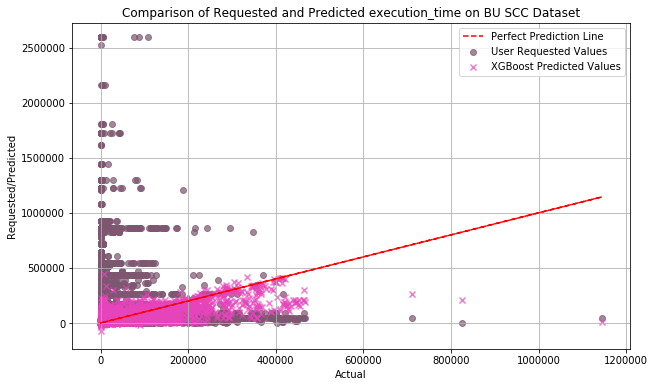

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


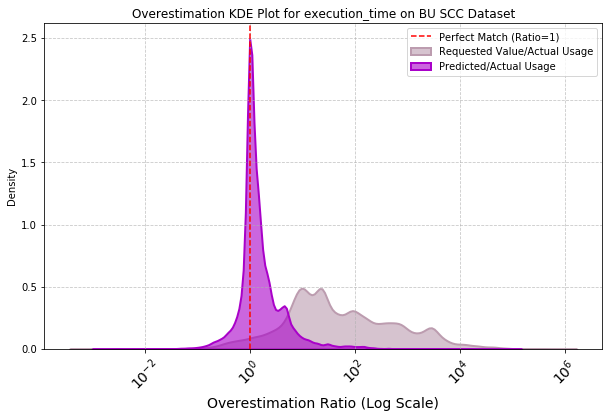

Processing cluster 10/10
Train size (X_train): 1514387
Test size (X_test): 378597
Train size (y_train): 1514387
Test size (y_test): 378597


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

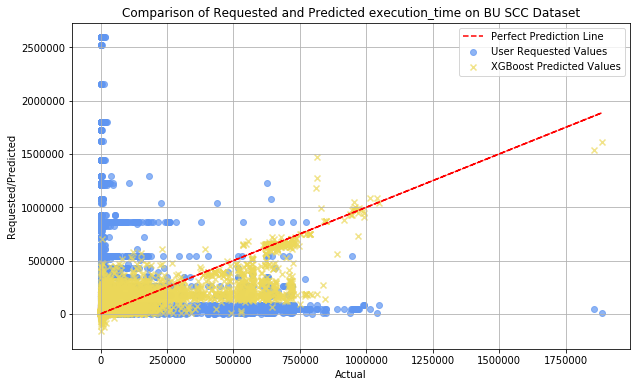

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


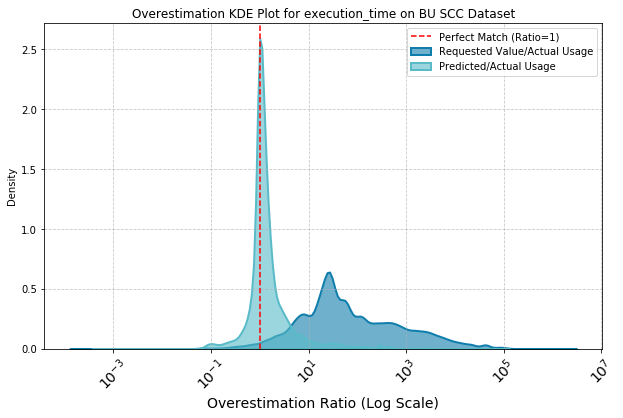

Average RMSE for Clustering: 13290.2306
Average MAE for Clustering: 2467.8102
Average R^2 for Clustering: 0.7666


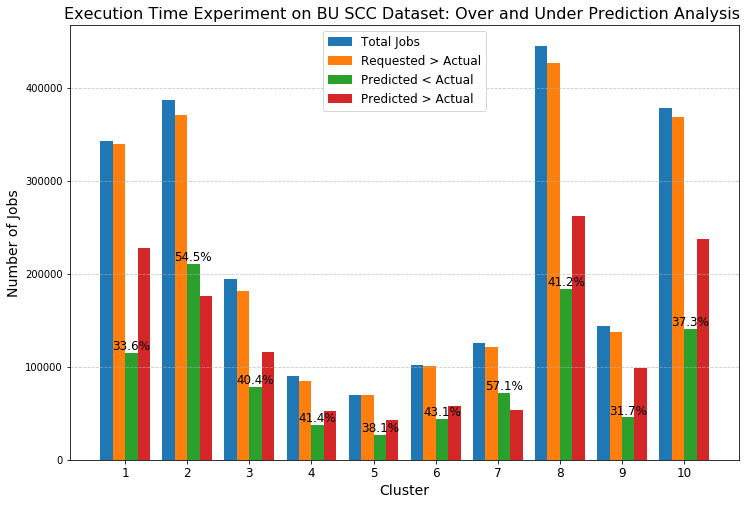

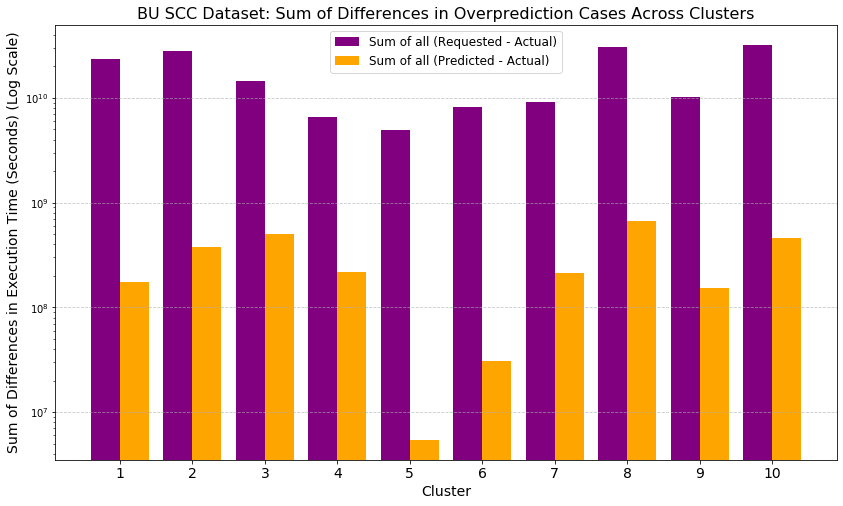

In [15]:
sub_dfs = cluster_create_sub_dataframes(df, train_features, ['execution_time'], 10)

rmse_list = []
mae_list = []
r2_list = []

metrics_data = []
overprediction_sums = []

for i, sub_df in enumerate(sub_dfs):
    print(f"Processing cluster {i+1}/{len(sub_dfs)}")
    
    rmse, mae, r2, y_test, y_pred, req_test= train_xgboost(sub_df, 'BU SCC Dataset', 'execution_time', train_features , 'h_rt')
    
    if rmse is not None:
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        total_jobs = len(y_test)
        requested_gt_target = (req_test > y_test).sum()
        predicted_lt_actual = (y_pred < y_test).sum()
        predicted_gt_actual = (y_pred > y_test).sum()

        op1 = y_pred > y_test
        op2 = req_test > y_test
        
        sum_predicted_minus_actual = (y_pred[op1] - y_test[op1]).sum()
        sum_requested_minus_actual = (req_test[op2] - y_test[op2]).sum()

        metrics_data.append([i + 1, total_jobs, requested_gt_target, predicted_lt_actual, predicted_gt_actual])
        overprediction_sums.append([sum_predicted_minus_actual, sum_requested_minus_actual])

        


rmse = np.mean(rmse_list)
print(f"Average RMSE for Clustering: {rmse:.4f}")
mae = np.mean(mae_list)
print(f"Average MAE for Clustering: {mae:.4f}")
r2 = np.mean(r2_list)
print(f"Average R^2 for Clustering: {r2:.4f}")


plot_everything(metrics_data, overprediction_sums, 
                'Execution Time Experiment on BU SCC Dataset: Over and Under Prediction Analysis ', 
                'BU SCC Dataset: Sum of Differences in Overprediction Cases Across Clusters',
                'Execution Time (Seconds)')
